<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  2 17:09:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   43C    P0    33W / 165W |  23512MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 32
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#   data_augmentation = Sequential([
#     tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomRotation(0.2),
#   ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
#   x = data_augmentation(inputs)

  x = tf.keras.applications.resnet50.preprocess_input(inputs)

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  # base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=base_learning_rate),3
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=25
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/25
720/720 [==============================] - 23s 23ms/step - loss: 0.6125 - accuracy: 0.7807 - val_loss: 0.4628 - val_accuracy: 0.8093
Epoch 2/25
720/720 [==============================] - 16s 23ms/step - loss: 0.3673 - accuracy: 0.8493 - val_loss: 0.4094 - val_accuracy: 0.8347
Epoch 3/25
720/720 [==============================] - 15s 21ms/step - loss: 0.3138 - accuracy: 0.8738 - val_loss: 0.3731 - val_accuracy: 0.8489
Epoch 4/25
720/720 [==============================] - 15s 21ms/step - loss: 0.2642 - accuracy: 0.8915 - val_loss: 0.4576 - val_accuracy: 0.8296
Epoch 5/25
720/720 [==============================] - 15s 21ms/step - loss: 0.2381 - accuracy: 0.9039 - val_loss: 0.4020 - val_accuracy: 0.8418
Epoch 6/25
720/720 [==============================] - 15s 21ms/step - loss: 0.2108 - accuracy: 0.9161 - val_loss: 0.4515 - val_accu

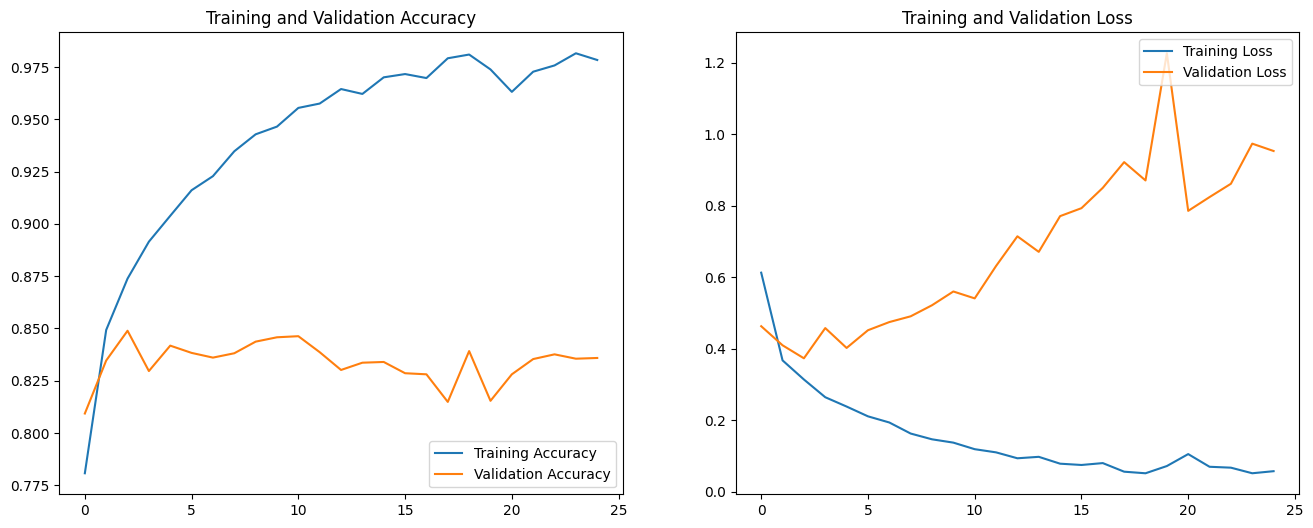

In [4]:
# Dense(128)
conf1 = train_model()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/25
720/720 [==============================] - 19s 21ms/step - loss: 0.6178 - accuracy: 0.7664 - val_loss: 0.4608 - val_accuracy: 0.8114
Epoch 2/25
720/720 [==============================] - 14s 20ms/step - loss: 0.4314 - accuracy: 0.8195 - val_loss: 0.4207 - val_accuracy: 0.8218
Epoch 3/25
720/720 [==============================] - 15s 20ms/step - loss: 0.3939 - accuracy: 0.8364 - val_loss: 0.4098 - val_accuracy: 0.8268
Epoch 4/25
720/720 [==============================] - 17s 24ms/step - loss: 0.3682 - accuracy: 0.8444 - val_loss: 0.4278 - val_accuracy: 0.8338
Epoch 5/25
720/720 [==============================] - 15s 21ms/step - loss: 0.3591 - accuracy: 0.8515 - val_loss: 0.3936 - val_accuracy: 0.8427
Epoch 6/25
720/720 [==============================] - 14s 20ms/step - loss: 0.3412 - accuracy: 0.8582 - val_loss: 0.4108 - val_accu

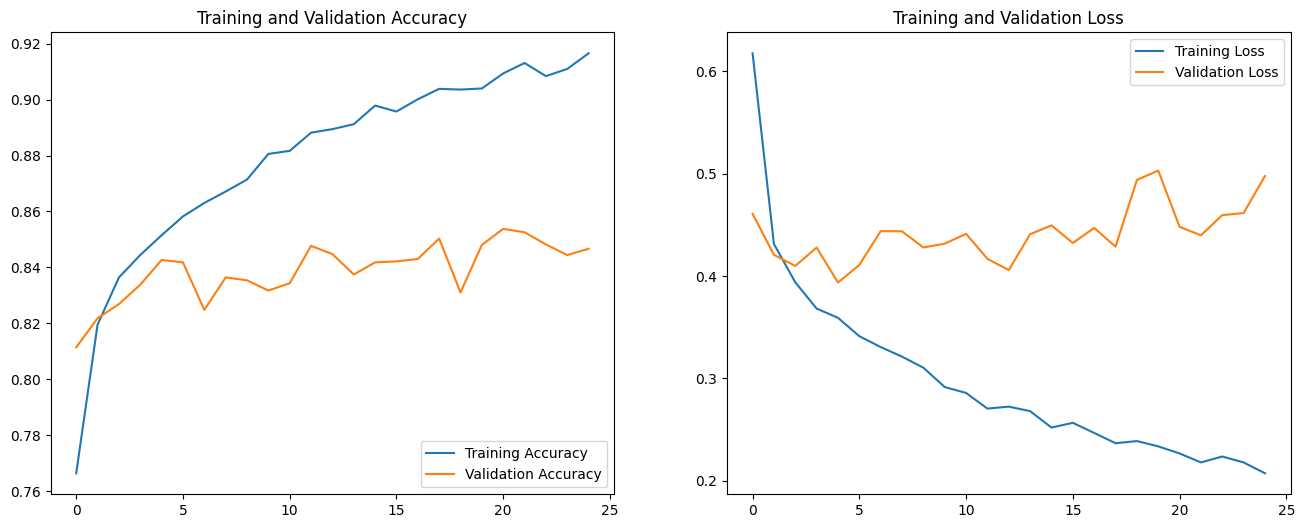

In [23]:
# Dense(128) + Dropout
conf2 = train_model()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/25
720/720 [==============================] - 19s 21ms/step - loss: 0.6076 - accuracy: 0.7720 - val_loss: 0.4527 - val_accuracy: 0.8173
Epoch 2/25
720/720 [==============================] - 14s 20ms/step - loss: 0.3758 - accuracy: 0.8462 - val_loss: 0.4258 - val_accuracy: 0.8300
Epoch 3/25
720/720 [==============================] - 15s 20ms/step - loss: 0.3226 - accuracy: 0.8667 - val_loss: 0.4337 - val_accuracy: 0.8328
Epoch 4/25
720/720 [==============================] - 15s 21ms/step - loss: 0.2819 - accuracy: 0.8867 - val_loss: 0.4006 - val_accuracy: 0.8352
Epoch 5/25
720/720 [==============================] - 15s 21ms/step - loss: 0.2454 - accuracy: 0.9018 - val_loss: 0.4632 - val_accuracy: 0.8260
Epoch 6/25
720/720 [==============================] - 17s 23ms/step - loss: 0.2088 - accuracy: 0.9189 - val_loss: 0.4041 - val_accu

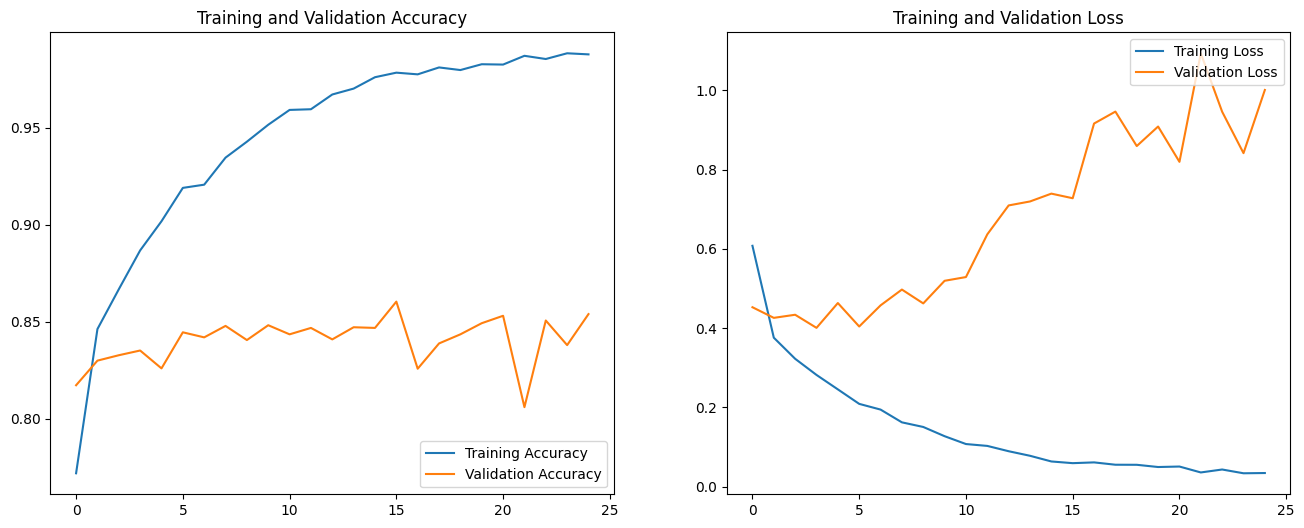

In [36]:
# Dense(128) + Dense(512)
conf3 = train_model()

In [ ]:
# Dense(128) + Dense(512) + Dropout
conf4 = train_model()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/25
720/720 [==============================] - 19s 21ms/step - loss: 0.7116 - accuracy: 0.7387 - val_loss: 0.4564 - val_accuracy: 0.8102
Epoch 2/25
720/720 [==============================] - 14s 20ms/step - loss: 0.4575 - accuracy: 0.8076 - val_loss: 0.4427 - val_accuracy: 0.8135
Epoch 3/25
720/720 [==============================] - 17s 23ms/step - loss: 0.4134 - accuracy: 0.8272 - val_loss: 0.4491 - val_accuracy: 0.8159
Epoch 4/25
720/720 [==============================] - 15s 20ms/step - loss: 0.3786 - accuracy: 0.8433 - val_loss: 0.4141 - val_accuracy: 0.8322
Epoch 5/25
720/720 [==============================] - 15s 20ms/step - loss: 0.3531 - accuracy: 0.8529 - val_loss: 0.4074 - val_accuracy: 0.8350
Epoch 6/25
720/720 [==============================] - 14s 20ms/step - loss: 0.3422 - accuracy: 0.8608 - val_loss: 0.3998 - val_accu

In [5]:
# pd.DataFrame(res_rgb).to_csv("resnet50_nontrainable/res_rgb.csv", index=False)